In [6]:
import sys
sys.path.insert(0, '../LIMEaid/controller')
sys.path.insert(0, '../LIMEaid/model')
sys.path.insert(0, '../LIMEaid/view')
import LIMEaid as la
import LIMEdisplay as ld
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import load_college_dataset as gcd
import fit_sklearn_models as fsm
from sklearn import preprocessing

# Number of perturbed samples to be generated.
n = 100000
# Number of bins for the histograms of continous attributes.
num_bins = 25

In [ ]:
def lime_display(full_data, lime_beta, lime_int):
    colors = ['k', 'b', 'm', 'c', 'g', 'y']
    classes = np.unique(full_data[:, -1])
    
    significant_attributes = 0
    for j in range(0, len(lime_beta)):
        if(lime_beta[j] != 0):
            significant_attributes = np.append(significant_attributes, j)
    significant_attributes = significant_attributes[1:]
        
    if (len(significant_attributes) == 2):
        # For visualization we separate perturbed samples classified
        # by the ML model as in-class, from those classified
        # out-of-class.
        in_class_data = full_data[full_data[:, 16] ==
                                  x_class]
        out_class_data = full_data[full_data[:, 16] !=
                                   x_class]

        plt.rcParams['figure.figsize'] = [10.0, 10.0]
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
        ax.scatter(out_class_data[:, significant_attributes[0]],
                   out_class_data[:, significant_attributes[1]],
                   marker='+', c='c', label='Out of class')
        ax.scatter(in_class_data[:, significant_attributes[0]],
                   in_class_data[:, significant_attributes[1]],
                   marker='x', c='b', label='In class')
        ax.scatter(x[significant_attributes[0]],
                   x[significant_attributes[1]], marker='o',
                   c='r', label='Instance')
        ticksx = ax.set_xticks([-2, -1.5, -1, -1.5, -0.5, 0, 0.5,
                                1, 1.5, 2, 2.5])
        ticksy = ax.set_yticks([-1, 0, 1, 2, 3, 4, 5, 6, 7])
        plt.grid(b=True, which='both', color='0.85', linestyle='-')
        ax.set_xlabel(features[significant_attributes[0]])
        ax.set_ylabel(features[significant_attributes[1]])
        plt.legend(loc='upper left')
    
    # Displaying regression values for perturbed samples.
    plt.rcParams['figure.figsize'] = [5.0, 10.0]
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)

    # Compute all LIME regression values for all perturbed samples
    # and for the instance to be explained, and plot them.
    for j in range(0, len(classes)):
        class_reg = full_data[full_data[:, -1] == classes[j]]
        class_reg = np.sum(class_reg[:, :-1] * lime_beta, axis=1) + lime_int
        ax.scatter(np.zeros(len(class_reg)) + j, class_reg, marker='o',
                   c=colors[j])
    instance = sum(x * lime_beta) + lime_int
    ax.scatter(x_class, instance, marker='o', c='r')
    ticksx = ax.set_xticks([0, 1, 2])
    labelsx = ax.set_xticklabels(['0', '1', '2'])
    ax.set_ylabel('LIME Regression')
    plt.grid(b=True, which='both', color='0.85', linestyle='-')

In [7]:
college = gcd.load_college_dataset()
features = list(college)[1:]
salary_class = np.array(college.iloc[:, 0])
college = np.array(college.iloc[:, 1:])

<_io.TextIOWrapper name='C:\\Users\\Castor18\\OneDrive\\MSDS_UW\\Data515_Spr19_Sw_Eng\\myproject\\LIMEaid\\LIMEaid\\model\\../data/Most-_Recent-_Cohorts-_Scorecard-_Elements.csv' mode='r' encoding='cp1252'>


In [9]:
clf = fsm.fit_multiclass_logistic_regression()

<_io.TextIOWrapper name='C:\\Users\\Castor18\\OneDrive\\MSDS_UW\\Data515_Spr19_Sw_Eng\\myproject\\LIMEaid\\LIMEaid\\model\\../data/Most-_Recent-_Cohorts-_Scorecard-_Elements.csv' mode='r' encoding='cp1252'>


In [10]:
perturbed_samples = la.lime_sample(n, False, college[:, 0], num_bins)
for j in range(1, college.shape[1]):
    array = college[:, j]
    output = la.lime_sample(n, True, array, num_bins)
    perturbed_samples = np.vstack((perturbed_samples, output))
perturbed_samples = np.transpose(perturbed_samples)

In [11]:
class_perturb_samples = clf.predict(perturbed_samples)

In [12]:
college_norm = preprocessing.scale(college)
# Selecting the instance to interpret.
inst_num = np.round(np.random.uniform(0, college_norm.shape[0], 1))
inst_num = inst_num[0].astype(int)
# x is the selected instance, and x_class is the class assigned
# by the decision tree. 
x = college_norm[inst_num, :]
x_class = salary_class[inst_num]

In [13]:
# We now fit the LIME linear model to get the coefficients and
# intercept, as well as the weight of each random sample, 
# based on its L2 distance to the instance that is being
# interpreted.
lime_beta, lime_int, lime_weigh = la.lime_fit(x,
                                              x_class,
                                              perturbed_samples,
                                              class_perturb_samples)

In [14]:
# Print output of LIME results.
print("Instance to be interpreted:")
for j in range(0, len(lime_beta)):
    print("Feature: ", features[j], "\tvalue: ",
          college[inst_num, j], "\tnormalized value: ",
          college_norm[inst_num, j])
print("Classification: ", x_class)
print("\nSignificant coefficients from LIME adjusted"
      " linear model:")
significant_attributes = 0
for j in range(0, len(lime_beta)):
    if(lime_beta[j] != 0):
        significant_attributes = np.append(significant_attributes, j)
        print("Feature: ", features[j],
              "\tCoefficient: ", lime_beta[j])
significant_attributes = significant_attributes[1:]
print("Intercept: ", lime_int)

Instance to be interpreted:
Feature:  HCM2 	value:  0.0 	normalized value:  0.0
Feature:  SATVR25 	value:  550.2231404958678 	normalized value:  1.5745653658398342e-15
Feature:  SATVR75 	value:  656.6280991735537 	normalized value:  -1.7634723214101526e-15
Feature:  SATMT25 	value:  563.5409836065573 	normalized value:  0.0
Feature:  SATMT75 	value:  669.2049180327868 	normalized value:  0.0
Feature:  SATWR25 	value:  561.528735632184 	normalized value:  -1.725927392195095e-15
Feature:  SATWR75 	value:  664.6896551724138 	normalized value:  0.0
Feature:  ACTCM25 	value:  20.0 	normalized value:  -1.06845139325279
Feature:  ACTCM75 	value:  25.0 	normalized value:  -1.2065591743080313
Feature:  ACTEN25 	value:  19.0 	normalized value:  -1.130451496769876
Feature:  ACTEN75 	value:  24.0 	normalized value:  -1.5552295784204275
Feature:  ACTMT25 	value:  19.0 	normalized value:  -1.084944377456212
Feature:  ACTMT75 	value:  25.0 	normalized value:  -1.175276890809284
Feature:  ACTWR25 	val

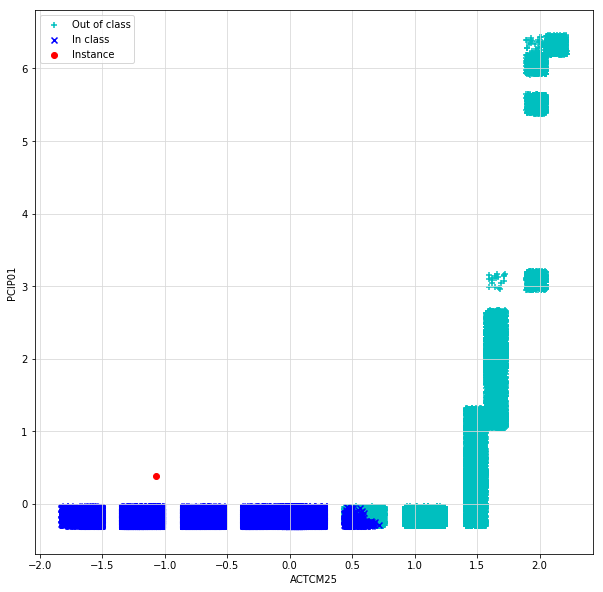

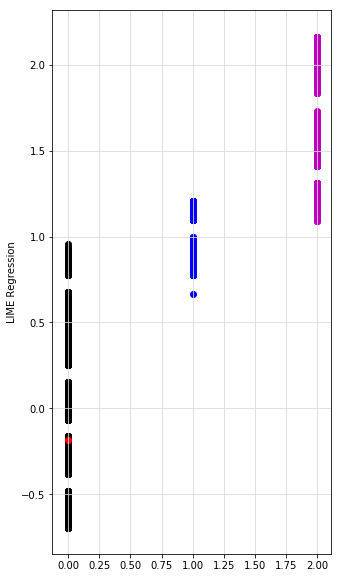

In [17]:
full_data = np.column_stack((perturbed_samples, class_perturb_samples))
ld.lime_display(full_data, lime_beta, lime_int, x, x_class, features)